✅ **Projet 2 — Analyse de sentiments sur des avis de films**

Objectif : Classer automatiquement les critiques de films (positif/négatif)

Techniques : LSTM, GRU, Word Embedding, Attention

📦 Dataset : IMDB Movie Review Dataset

🔧 Tâches :

•	Tokenisation, padding

•	Embedding layer

•	Modèle LSTM ou GRU

•	Visualisation des résultats

•	Comparaison avec baseline

**Les RNN (Recurrent Neural Networks)** lisent les mots un par un, en gardant une mémoire des mots précédents.

Mais … Quand la phrase devient longue, les RNN oublient les premiers mots.
**Solution:**
1) ***LSTM (Long Short-Term Memory)***


Le LSTM est une version intelligente du RNN qui apprend quoi retenir et quoi oublier grâce à trois portes ("gates") :

 . Les 3 portes du LSTM

Forget Gate (porte d’oubli) → Décide quelle information ancienne on efface.

Input Gate (porte d’entrée)
→ Choisit quelles nouvelles infos on garde dans la mémoire.

Output Gate (porte de sortie)
→ Décide quelle partie de la mémoire sera utilisée pour la prédiction actuelle.

2) **GRU (Gated Recurrent Unit)**

Le GRU est une version simplifiée et plus rapide du LSTM.


Il a 2 portes :

Update gate → mélange de forget + input

Reset gate → contrôle combien du passé on garde

In [ ]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Dense, Dropout, Input, Layer
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
import tarfile, urllib.request, os

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#stopwords = mots très fréquents sans grande valeur sémantique : “the”, “is”, etc .

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


if not os.path.exists("aclImdb"):
    print("Téléchargement du dataset IMDB...")
    urllib.request.urlretrieve(url, "aclImdb_v1.tar.gz") #télécharge l’archive localement
    with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
        tar.extractall() #extrait tout le contenu dans le répertoire courant.

Téléchargement du dataset IMDB...


/tmp/ipython-input-1958263869.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


In [ ]:
# Fonction pour lire les fichiers
def load_imdb_data(directory):
    texts, labels = [], []
    for label_type in ['pos', 'neg']:
        dir_path = os.path.join(directory, label_type)
        for fname in os.listdir(dir_path):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_path, fname), encoding='utf-8') as f:
                    texts.append(f.read())
                labels.append(1 if label_type == 'pos' else 0)
    return pd.DataFrame({'review': texts, 'sentiment': labels})

In [ ]:
# Chargement train et test
train_df = load_imdb_data("aclImdb/train")
test_df = load_imdb_data("aclImdb/test")
df = pd.concat([train_df, test_df]).sample(frac=1).reset_index(drop=True)

print(f"Total d'avis : {len(df)}")
print(df.head())

Total d'avis : 50000
                                              review  sentiment
0  Terry Gilliam traveled again to the future (he...          1
1  Excellent plot within a plot within a plot. Sh...          1
2  I have read the whole 'A wrinkle in time' book...          0
3  This movie is excellent and I would recommend ...          1
4  I'm normally a sucker for romantic films which...          1


In [ ]:
# Nettoyage du texte
def clean_text(text):
    text = text.lower()                              # minuscule
    text = re.sub(r'<.*?>', '', text)                # retirer tags HTML
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # ponctuation
    text = re.sub(r'\d+', '', text)                  # chiffres
    words = text.split()
    words = [w for w in words if w not in stop_words]  # retirer stopwords
    return " ".join(words)

print("Nettoyage des textes...")
df['clean_review'] = df['review'].apply(clean_text)

Nettoyage des textes...


In [ ]:
# Tokenisation et Padding
# Tokenisation = transformer un texte brut en une suite de petits éléments appelés “tokens”, souvent des mots ou des sous-mots
# "This movie was really good!" ==>  ["this", "movie", "was", "really", "good"]
#Chaque mot reçoit un indice numérique unique
#"This movie was good" → [1, 15, 45, 87]
# Les réseaux de neurones (LSTM, GRU, etc.) ne comprennent pas les mots, ils ne comprennent que les nombres
# Donc on transforme le texte → chiffres → vecteurs → modèle
max_words = 10000 #on limite le vocabulaire aux 10 000 mots les plus fréquents (pour réduire la taille et la mémoire).
max_len = 200 #longueur fixe de chaque séquence

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_review']) #apprend le vocabulaire et la fréquence.
sequences = tokenizer.texts_to_sequences(df['clean_review']) #transforme chaque texte en une liste d’indices entiers (un entier par mot)
X = pad_sequences(sequences, maxlen=max_len) #Le padding rend toutes les phrases de même longueur
y = np.array(df['sentiment'])


In [ ]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train: {y_train.shape}")

X_train shape: (40000, 200), y_train: (40000,)


In [ ]:
# Modèle LSTM
model_lstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])

print("\n🔹 Entraînement du modèle LSTM...")
history_lstm = model_lstm.fit(X_train, y_train, validation_split=0.2, epochs=3, batch_size=128)



🔹 Entraînement du modèle LSTM...
Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.7228 - loss: 0.5294 - val_accuracy: 0.8785 - val_loss: 0.3048
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.8889 - loss: 0.2816 - val_accuracy: 0.8640 - val_loss: 0.3135
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.9087 - loss: 0.2421 - val_accuracy: 0.8662 - val_loss: 0.3341


In [ ]:
#  Modèle GRU
model_gru = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    GRU(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])

print("\n🔹 Entraînement du modèle GRU...")
history_gru = model_gru.fit(X_train, y_train, validation_split=0.2, epochs=3, batch_size=128)


🔹 Entraînement du modèle GRU...
Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 250s 985ms/step - accuracy: 0.6842 - loss: 0.5691 - val_accuracy: 0.8145 - val_loss: 0.4075
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 244s 976ms/step - accuracy: 0.8529 - loss: 0.3500 - val_accuracy: 0.8610 - val_loss: 0.3253
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.9005 - loss: 0.2555 - val_accuracy: 0.8744 - val_loss: 0.3092


In [ ]:
#  Évaluation
lstm_acc = model_lstm.evaluate(X_test, y_test, verbose=0)[1]
gru_acc = model_gru.evaluate(X_test, y_test, verbose=0)[1]

print(f"\n Précision LSTM : {lstm_acc:.4f}")
print(f" Précision GRU  : {gru_acc:.4f}")


 Précision LSTM : 0.8640
 Précision GRU  : 0.8703


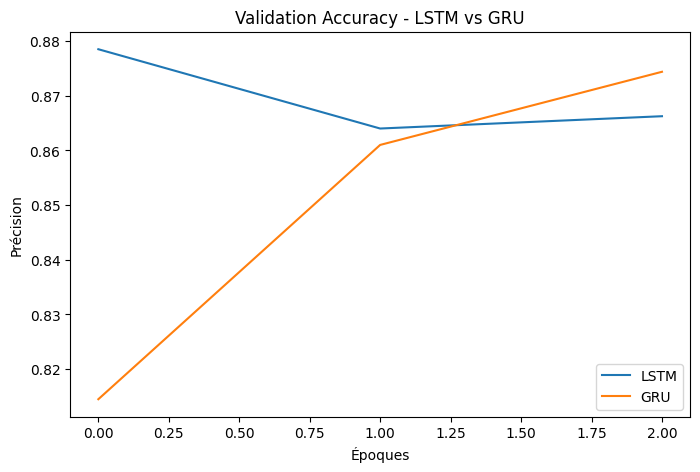

In [ ]:
#  Visualisation des performances
plt.figure(figsize=(8,5))
plt.plot(history_lstm.history['val_accuracy'], label='LSTM')
plt.plot(history_gru.history['val_accuracy'], label='GRU')
plt.title("Validation Accuracy - LSTM vs GRU")
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.legend()
plt.show()

In [ ]:
model_gru.save("sentiment_model.h5")


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("sentiment_model.h5")


In [ ]:
sentence = ["The movie was so boring and slow..."]

seq = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)

if pred[0][0] > 0.5:
    print(" Sentiment positif")
else:
    print(" Sentiment négatif")

print("Probabilité:", float(pred[0][0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
 Sentiment négatif
Probabilité: 0.050703804939985275


In [ ]:
sentence2 = ["The movie was amazing..."]

seq2 = tokenizer.texts_to_sequences(sentence2)
padded2 = pad_sequences(seq2, maxlen=max_len)
pred2 = model.predict(padded2)

if pred2[0][0] > 0.5:
    print(" Sentiment positif")
else:
    print(" Sentiment négatif")

print("Probabilité:", float(pred[0][0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
 Sentiment positif
Probabilité: 0.050703804939985275
